In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy import signal
import os
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error


setting = pd.read_csv('Settings.csv', header=None)

DEMG_file = setting.iloc[0, 1]
output_path = setting.iloc[1, 1]
output_name = setting.iloc[2, 1]


DEMGs = pd.read_csv(DEMG_file, header=11)
time_DEMG = pd.read_csv(DEMG_file, header=11, usecols = [1])
# time_RMS = pd.read_csv(RMS_file, header=14, usecols = [1])

#file_name = "M01.csv" 
data = pd.read_csv(DEMG_file, header=11)
data.dropna(inplace=True)
len(data)
print(len(data))
print(data)

data.describe()


C:\Users\ibra5\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\ibra5\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


143050
          X [s]  \
0         0.000   
1         0.001   
2         0.002   
3         0.003   
4         0.004   
...         ...   
143045  143.045   
143046  143.046   
143047  143.047   
143048  143.048   
143049  143.049   

        Trigno IM sensor 1: EMG 1 (IM)->Subset->Filter->Slope [Volts/s]  \
0                                                0.011785                 
1                                                0.004563                 
2                                               -0.011069                 
3                                               -0.019290                 
4                                               -0.018436                 
...                                                   ...                 
143045                                          -0.122741                 
143046                                          -0.132011                 
143047                                          -0.090055                 
143048        

,X [s],Trigno IM sensor 1: EMG 1 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 2: EMG 2 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 3: EMG 3 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 4: EMG 4 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 5: EMG 5 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 6: EMG 6 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 7: EMG 7 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 8: EMG 8 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 9: EMG 9 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 10: EMG 10 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 11: EMG 11 (IM)->Subset->Filter->Slope [Volts/s]
count,143050.000000,143050.000000,143050.000000,143050.000000,143050.000000,143050.000000,143050.000000,143050.000000,143050.000000,143050.000000,143050.000000,143050.000000
mean,71.524500,0.000015,0.000017,0.000019,0.000017,0.000018,0.000018,0.000019,0.000016,0.000019,0.000016,0.000025
std,41.295122,0.088392,0.101025,0.163136,0.011495,0.011103,0.010879,0.042463,0.056268,0.027140,0.040801,0.084913
min,0.000000,-1.037802,-0.863302,-1.957073,-0.344924,-0.169217,-0.150227,-0.908791,-0.564911,-0.390452,-0.347454,-0.976327
25%,35.762250,-0.013890,-0.022706,-0.034076,-0.007120,-0.007229,-0.007050,-0.010528,-0.013801,-0.010216,-0.014078,-0.034821
50%,71.524500,-0.000864,-0.000960,0.002961,-0.000211,-0.000224,-0.000217,-0.000753,-0.001315,0.000015,-0.000501,0.000804
75%,107.286750,0.011876,0.019141,0.041411,0.006904,0.007027,0.006877,0.009023,0.010496,0.010630,0.012976,0.036116
max,143.049000,0.952088,0.952242,1.052990,0.942552,0.949364,0.939848,0.947463,0.964964,0.962288,0.958153,0.941149


### Find AR Coefficients and Calculate the RMS value

In [2]:
# Define the RMS function
from math import sqrt
import statistics

def notch_filter(data, fs = 1000, f0 = 50, Q = 30):
    b, a = signal.iirnotch(f0, Q, fs)
    return sp.signal.filtfilt(b, a, data)
def get_max(data):
    return max(abs(data))
def get_normalized(data, max_data):
    return data/max_data
def get_AR_coeffs(data, num_coeff = 6):
    model = AR(data)
    model_fit = model.fit(maxlag = num_coeff, disp=False)
    return model_fit.params
def get_RMS(data):
    return sqrt(sum(n*n for n in data)/len(data))
def get_MAV(data):
    return sum(abs(n) for n in data)/len(data)
def remove_artifact(data):
    mean_value = statistics.mean(abs(data))
    print(mean_value)
    for i in range(len(data)):
        if abs(data[i]) > (mean_value*20):
            data[i] = data[i]/5
    return data

In [3]:
step = 0.05
time_limit = max(DEMGs['X [s]'])
print(time_limit)
EMG_nums = 11
count_flag = False 
for EMG_num in range(EMG_nums):
    start = 0
    end = 0.1
    coeff = []
    count = 0
    time = []
    RMS = []
    MAV = []
    EMG_label = "Trigno IM sensor " + f'{EMG_num + 1}' + ": EMG " + f'{EMG_num + 1}' + " (IM)->Subset->Filter->Slope [Volts/s]"
    #Filter the data
    notch_filtered_DEMG_data = notch_filter(DEMGs[EMG_label])
    #print("notch_filtered_DEMG_data:", notch_filtered_DEMG_data)
    
    if (EMG_num == 9):
        filtered_DEMG_data = remove_artifact(notch_filtered_DEMG_data)
    else:
        filtered_DEMG_data = notch_filtered_DEMG_data
        #print("filtered_DEMG_data:", filtered_DEMG_data)
#     #Get max value
    max_DEMG = get_max(filtered_DEMG_data)
    #print("max_DEMG:", max_DEMG)
#     #Normalised data
    normalised_DEMG = get_normalized(filtered_DEMG_data,max_DEMG)
    #print("normalised_DEMG:", normalised_DEMG)
     
    while (end<time_limit):
        df = normalised_DEMG[(DEMGs['X [s]']>=start) & (DEMGs['X [s]'] < end)]
        DEMG_value = np.array(df[:])
        # Print the values in DEMG_value
        #print("DEMG_value:", DEMG_value)
        
        #Get the RMS
        DEMG_RMS_value = get_RMS(DEMG_value)
        
        #Get the MAV
        DEMG_MAV_value = get_MAV(DEMG_value)
        
        #Get the AR coefficients
        coef_temp = get_AR_coeffs(DEMG_value)

        start = start + step
        end = end + step
        if not count_flag:
            time.append(count*step)
            count = count + 1
        
        RMS.append(DEMG_RMS_value)
        MAV.append(DEMG_MAV_value)
        coeff.append(coef_temp)
        
    if not count_flag:
        time = np.array(time)
        dataset = pd.DataFrame({'Time': time})
        count_flag = True
        
    coeff = np.array(coeff)
    RMS = np.array(RMS)
    MAV = np.array(MAV)
    
    dataset_temp =  pd.DataFrame({'DEMG' + f'{EMG_num + 1}' + '_AR1':coeff[:,1], 'DEMG' + f'{EMG_num + 1}' + '_AR2':coeff[:,2], 'DEMG' + f'{EMG_num + 1}' + '_AR3':coeff[:,3], \
'DEMG' + f'{EMG_num + 1}' + '_AR4':coeff[:,4], 'DEMG' + f'{EMG_num + 1}' + '_AR5':coeff[:,5], 'DEMG' + f'{EMG_num + 1}' + '_AR6':coeff[:,6], 'DEMG' + f'{EMG_num + 1}' + '_RMS': RMS, 'DEMG' + f'{EMG_num + 1}' + '_MAV': MAV})
#     dataset_temp =  pd.DataFrame({'DEMG' + f'{EMG_num + 1}' + '_AR1':coeff[:,1], 'DEMG' + f'{EMG_num + 1}' + '_AR2':coeff[:,2], 'DEMG' + f'{EMG_num + 1}' + '_AR3':coeff[:,3], \
# 'DEMG' + f'{EMG_num + 1}' + '_AR4':coeff[:,4], 'DEMG' + f'{EMG_num + 1}' + '_AR5':coeff[:,5], 'DEMG' + f'{EMG_num + 1}' + '_AR6':coeff[:,6], 'DEMG' + f'{EMG_num + 1}' + '_RMS': RMS})
    dataset = pd.concat([dataset,dataset_temp], axis = 1)
dataset.describe()

143.049


C:\Users\ibra5\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, 

0.024609780579237236


C:\Users\ibra5\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, 

,Time,DEMG1_AR1,DEMG1_AR2,DEMG1_AR3,DEMG1_AR4,DEMG1_AR5,DEMG1_AR6,DEMG1_RMS,DEMG1_MAV,DEMG2_AR1,...,DEMG10_RMS,DEMG10_MAV,DEMG11_AR1,DEMG11_AR2,DEMG11_AR3,DEMG11_AR4,DEMG11_AR5,DEMG11_AR6,DEMG11_RMS,DEMG11_MAV
count,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,...,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000
mean,71.450000,1.380106,-1.644495,1.440652,-1.337443,0.838163,-0.473116,0.055613,0.039780,1.443385,...,0.074697,0.057142,1.812456,-2.029446,1.819154,-1.569967,0.979691,-0.423396,0.075927,0.057835
std,41.273327,0.289898,0.403871,0.484820,0.316033,0.189667,0.112784,0.063269,0.047661,0.223943,...,0.055550,0.042132,0.285793,0.491345,0.511898,0.382178,0.226278,0.091990,0.042562,0.032468
min,0.000000,0.507490,-3.177937,-0.010432,-3.057713,-0.015791,-0.984290,0.007402,0.005577,0.532729,...,0.017781,0.014493,0.600018,-3.617809,-0.079832,-2.897975,0.048348,-0.745286,0.014166,0.011424
25%,35.725000,1.167320,-1.901221,1.065225,-1.526429,0.707839,-0.551391,0.012349,0.009870,1.288132,...,0.028414,0.022894,1.620849,-2.377735,1.421853,-1.831021,0.819144,-0.485418,0.044443,0.033575
50%,71.450000,1.375530,-1.610520,1.406614,-1.282682,0.827986,-0.476694,0.020099,0.014458,1.441179,...,0.052758,0.039646,1.831736,-2.011863,1.777143,-1.539059,0.971394,-0.426352,0.067277,0.051209
75%,107.175000,1.578975,-1.327982,1.747510,-1.106013,0.957609,-0.399239,0.084433,0.053743,1.598832,...,0.111989,0.084560,2.014874,-1.648087,2.180286,-1.275667,1.130741,-0.362965,0.097818,0.074301
max,142.900000,2.216413,0.229601,3.393479,0.069198,1.968012,0.016582,0.345069,0.281311,2.307932,...,0.302555,0.235829,2.555372,0.236088,3.585404,-0.147788,1.827665,0.012055,0.308433,0.257545


In [4]:
step = 0.05
time_limit = max(DEMGs['X [s]'])
print(time_limit)
EMG_nums = 11
count_flag = False 
for EMG_num in range(EMG_nums):
    start = 0
    end = 0.1
    coeff = []
    count = 0
    time = []
    RMS = []
    MAV = []
    EMG_label = "Trigno IM sensor " + f'{EMG_num + 1}' + ": EMG " + f'{EMG_num + 1}' + " (IM)->Subset->Filter->Slope [Volts/s]"
    #Filter the data
    filtered_DEMG_data = notch_filter(DEMGs[EMG_label])
    #Get max value
    max_DEMG = get_max(filtered_DEMG_data)
    #Normalised data
    normalised_DEMG = get_normalized(filtered_DEMG_data,max_DEMG)
     
    while (end<time_limit):
        df = normalised_DEMG[(DEMGs['X [s]']>=start) & (DEMGs['X [s]'] < end)]
        DEMG_value = np.array(df[:])
        
        #Get the RMS
        DEMG_RMS_value = get_RMS(DEMG_value)
        
        #Get the MAV
        DEMG_MAV_value = get_MAV(DEMG_value)
        
        #Get the AR coefficients
        coef_temp = get_AR_coeffs(DEMG_value)

        start = start + step
        end = end + step
        if not count_flag:
            time.append(count*step)
            count = count + 1
        
        RMS.append(DEMG_RMS_value)
        MAV.append(DEMG_MAV_value)
        coeff.append(coef_temp)
        
    if not count_flag:
        time = np.array(time)
        dataset = pd.DataFrame({'Time': time})
        count_flag = True
        
    coeff = np.array(coeff)
    RMS = np.array(RMS)
    MAV = np.array(MAV)
    
    dataset_temp =  pd.DataFrame({'DEMG' + f'{EMG_num + 1}' + '_AR1':coeff[:,1], 'DEMG' + f'{EMG_num + 1}' + '_AR2':coeff[:,2], 'DEMG' + f'{EMG_num + 1}' + '_AR3':coeff[:,3], \
'DEMG' + f'{EMG_num + 1}' + '_AR4':coeff[:,4], 'DEMG' + f'{EMG_num + 1}' + '_AR5':coeff[:,5], 'DEMG' + f'{EMG_num + 1}' + '_AR6':coeff[:,6], 'DEMG' + f'{EMG_num + 1}' + '_RMS': RMS, 'DEMG' + f'{EMG_num + 1}' + '_MAV': MAV})
#     dataset_temp =  pd.DataFrame({'DEMG' + f'{EMG_num + 1}' + '_AR1':coeff[:,1], 'DEMG' + f'{EMG_num + 1}' + '_AR2':coeff[:,2], 'DEMG' + f'{EMG_num + 1}' + '_AR3':coeff[:,3], \
# 'DEMG' + f'{EMG_num + 1}' + '_AR4':coeff[:,4], 'DEMG' + f'{EMG_num + 1}' + '_AR5':coeff[:,5], 'DEMG' + f'{EMG_num + 1}' + '_AR6':coeff[:,6], 'DEMG' + f'{EMG_num + 1}' + '_RMS': RMS})
    dataset = pd.concat([dataset,dataset_temp], axis = 1)
dataset.describe()

143.049


C:\Users\ibra5\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, 

C:\Users\ibra5\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, 

,Time,DEMG1_AR1,DEMG1_AR2,DEMG1_AR3,DEMG1_AR4,DEMG1_AR5,DEMG1_AR6,DEMG1_RMS,DEMG1_MAV,DEMG2_AR1,...,DEMG10_RMS,DEMG10_MAV,DEMG11_AR1,DEMG11_AR2,DEMG11_AR3,DEMG11_AR4,DEMG11_AR5,DEMG11_AR6,DEMG11_RMS,DEMG11_MAV
count,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,...,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000
mean,71.450000,1.380106,-1.644495,1.440652,-1.337443,0.838163,-0.473116,0.055613,0.039780,1.443385,...,0.033850,0.025867,1.812456,-2.029446,1.819154,-1.569967,0.979691,-0.423396,0.075927,0.057835
std,41.273327,0.289898,0.403871,0.484820,0.316033,0.189667,0.112784,0.063269,0.047661,0.223943,...,0.025273,0.019074,0.285793,0.491345,0.511898,0.382178,0.226278,0.091990,0.042562,0.032468
min,0.000000,0.507490,-3.177937,-0.010432,-3.057713,-0.015791,-0.984290,0.007402,0.005577,0.532729,...,0.008046,0.006558,0.600018,-3.617809,-0.079832,-2.897975,0.048348,-0.745286,0.014166,0.011424
25%,35.725000,1.167320,-1.901221,1.065225,-1.526429,0.707839,-0.551391,0.012349,0.009870,1.288132,...,0.012857,0.010359,1.620849,-2.377735,1.421853,-1.831021,0.819144,-0.485418,0.044443,0.033575
50%,71.450000,1.375530,-1.610520,1.406614,-1.282682,0.827986,-0.476694,0.020099,0.014458,1.441179,...,0.023872,0.017939,1.831736,-2.011863,1.777143,-1.539059,0.971394,-0.426352,0.067277,0.051209
75%,107.175000,1.578975,-1.327982,1.747510,-1.106013,0.957609,-0.399239,0.084433,0.053743,1.598832,...,0.050672,0.038302,2.014874,-1.648087,2.180286,-1.275667,1.130741,-0.362965,0.097818,0.074301
max,142.900000,2.216413,0.229601,3.393479,0.069198,1.968012,0.016582,0.345069,0.281311,2.307932,...,0.138225,0.106707,2.555372,0.236088,3.585404,-0.147788,1.827665,0.012055,0.308433,0.257545


### Plot RMS graphs for each muscle of interest

In [5]:
label = ['gastrocmed','Tibialisanterior','Soleus','Vastusmedialis','Vastuslateralis','Rectusfemoris','BicepsFemoris','Semitendinosus', 'Gracilis', 'gluteusmedius', 'rightexternaloblique']
legends = ['MuscleName']
def plot(time, Y1, label):    
    plt.plot(time, Y1, 'r')
    plt.legend(legends, loc = 'upper right')
    plt.xlabel('Time [s]')
#     y_label = 'Volts/s'
#     plt.ylabel(y_label)
    plt.title(label)
#plt.savefig('plots/' + label + '.pdf')
    plt.show()

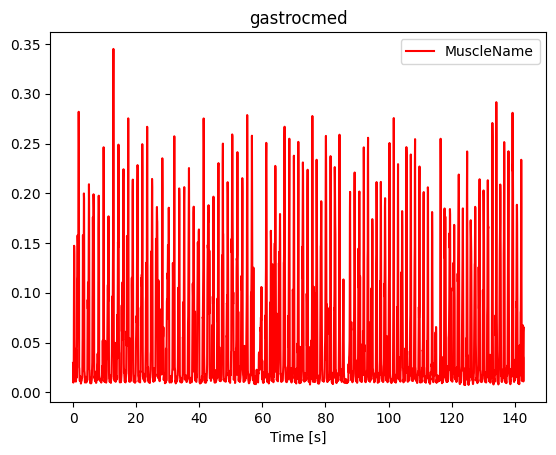

In [6]:
#Rectus Femoris
# plot(dataset.loc[1750:1800,'Time'],dataset.loc[1750:1800,'DEMG13_RMS'],dataset.loc[1750:1800,'DEMG14_RMS'], label[0])
plot(dataset['Time'],dataset['DEMG1_RMS'], label[0])

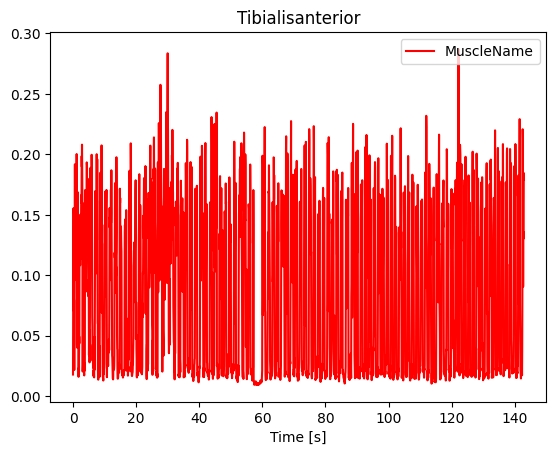

In [7]:
#Bicep Femoris
plot(dataset['Time'],dataset['DEMG2_RMS'], label[1])

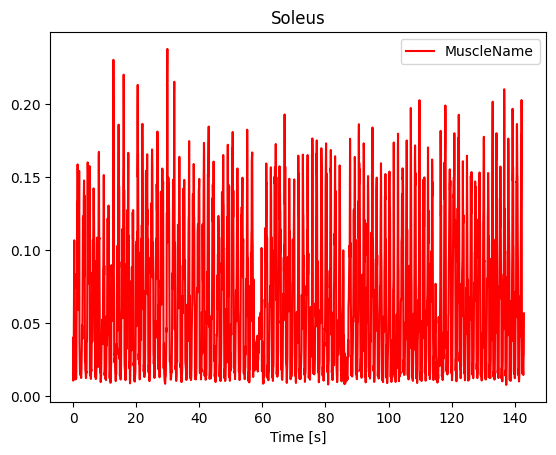

In [8]:
#Vastus Lateralis
# plot(dataset.loc[2080:2120,'Time'],dataset.loc[2080:2120,'DEMG6_RMS'],dataset.loc[2080:2120,'DEMG6_RMS'], label[0])
plot(dataset['Time'],dataset['DEMG3_RMS'], label[2])

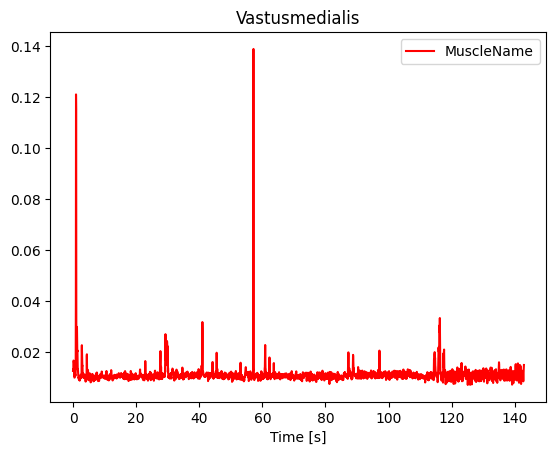

In [9]:
#Semitedinonius
plot(dataset['Time'],dataset['DEMG4_RMS'], label[3])

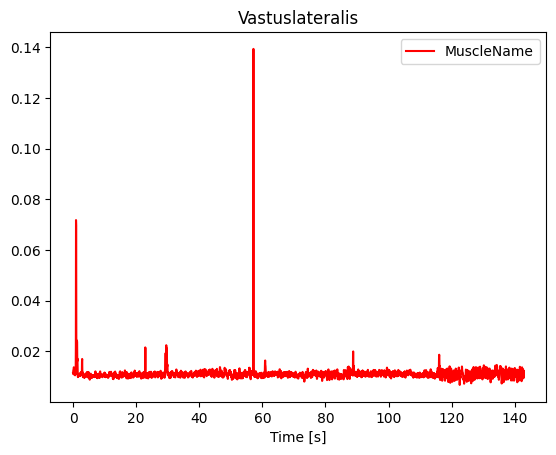

In [10]:
#Tibialis Anterior
plot(dataset['Time'],dataset['DEMG5_RMS'], label[4])

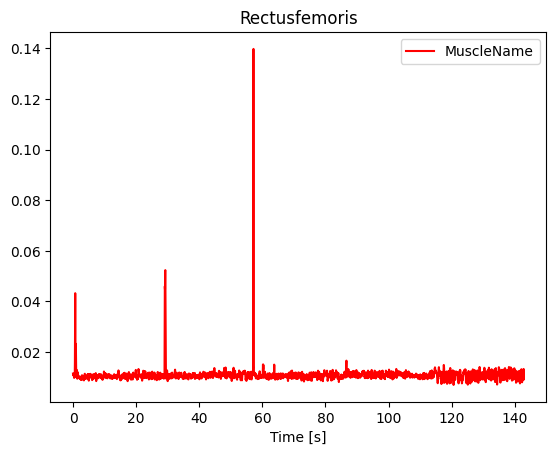

In [11]:
#Gastromedius
plot(dataset['Time'],dataset['DEMG6_RMS'], label[5])

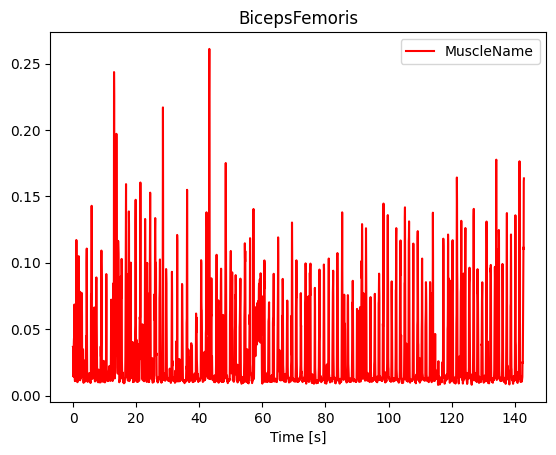

In [12]:
#Soleus
plot(dataset['Time'],dataset['DEMG7_RMS'], label[6])


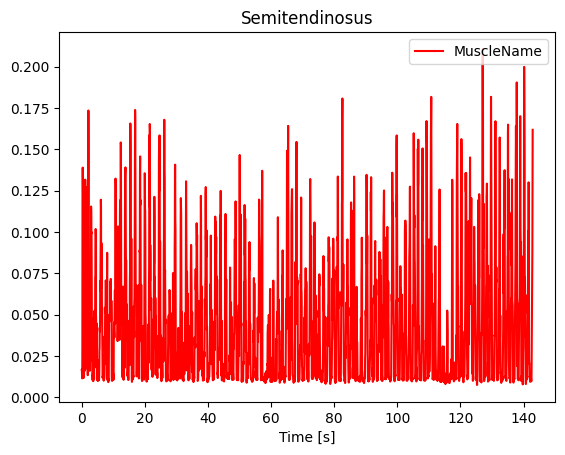

In [13]:
plot(dataset['Time'],dataset['DEMG8_RMS'], label[7])

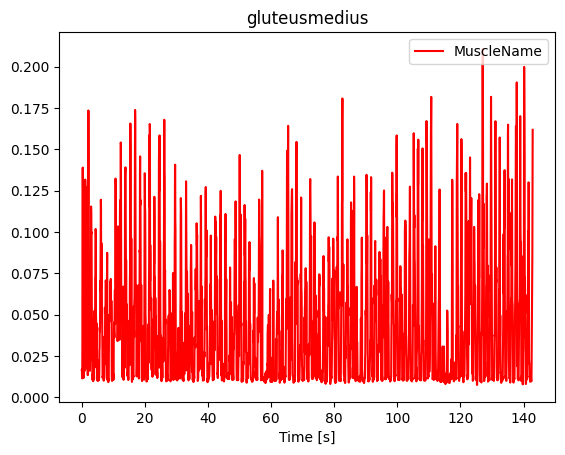

In [14]:
plot(dataset['Time'],dataset['DEMG8_RMS'], label[9])

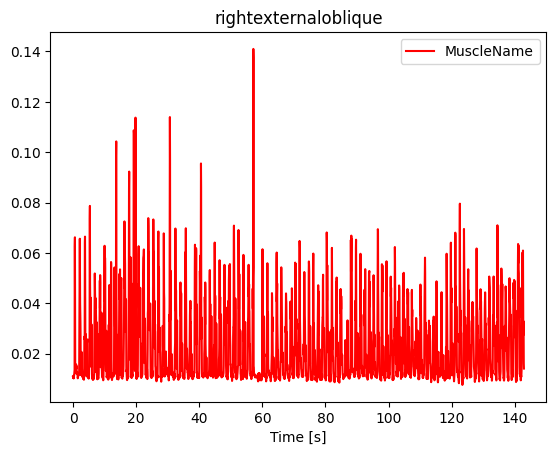

In [15]:
plot(dataset['Time'],dataset['DEMG9_RMS'], label[10])

### Save the output

In [16]:
output_file = output_path + output_name + '.csv'
dataset.to_csv(output_file, index = False)